In [ ]:
#| echo: false

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# Multiple Seasonal Trend (MSTL)

> Step-by-step guide on using the `MSTL Model` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

The text in this article is largely taken from:
1. [Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python.](https://link.springer.com/book/10.1007/978-3-031-13584-2) 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html).

## Table of Contents

* [Introduction](#introduction)
* [IMAPA Model](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of IMAPA with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction <a class="anchor" id="introduction"></a>


The MSTL model (Multiple Seasonal-Trend decomposition using LOESS) is a method used to decompose a time series into its seasonal, trend and residual components. This approach is based on the use of LOESS (Local Regression Smoothing) to estimate the components of the time series.

The MSTL decomposition is an extension of the classic seasonal-trend decomposition method (also known as Holt-Winters decomposition), which is designed to handle situations where multiple seasonal patterns exist in the data. This can occur, for example, when a time series exhibits daily, weekly, and yearly patterns simultaneously.

The MSTL decomposition process is performed in several stages:

1. Trend estimation: LOESS is used to estimate the trend component of the time series. LOESS is a non-parametric smoothing method that locally fits data and allows complex trend patterns to be captured.

2. Estimation of seasonal components: Seasonal decomposition techniques are applied to identify and model the different seasonal patterns present in the data. This involves extracting and modeling seasonal components, such as daily, weekly, or yearly patterns.

3. Estimation of the residuals: The residuals are calculated as the difference between the original time series and the sum of the estimates of trend and seasonal components. Residuals represent variation not explained by trend and seasonal patterns and may contain additional information or noise.

MSTL decomposition allows you to analyze and understand the different components of a time series in more detail, which can make it easier to forecast and detect patterns or anomalies. Furthermore, the use of LOESS provides flexibility to adapt to different trend and seasonal patterns present in the data.

It is important to note that the MSTL model is only one of the available approaches for time series decomposition and that its choice will depend on the specific characteristics of the data and the application context.

## MSTL <a class="anchor" id="model"></a>

An important objective in time series analysis is the decomposition of a series into a set of non-observable (latent) components that can be associated with different types of temporal variations. The idea of time series decomposition is very old and was used for the calculation of planetary orbits by seventeenth century astronomers. Persons was the first to state explicitly the assumptions of unobserved components. As Persons saw it, time series was composed of four types of fluctuations:

1. a long-term tendency or secular trend;
2. cyclical movements superimposed upon the long-term trend. These cycles appear to reach their peaks during periods of industrial prosperity and their troughs during periods of depressions, their rise and fall constituting the business cycle;
3. a seasonal movement within each year, the shape of which depends on the nature of the series;
4. residual variations due to changes impacting individual variables or other major events, such as wars and national catastrophes affecting a number of variables.

Traditionally, the four variations have been assumed to be mutually independent from one another and specified by means of an additive decomposition model:



$$
\begin{equation}
y_t= T_t +C_t +S_t +I_t, t=1,\ \cdots, n  \tag 1
\end{equation}
$$


where $y_t$ denotes the observed series at time $t$, $T_t$ the long-term trend, $C_t$ the business cycle, $S_t$ seasonality, and $I_t$ the irregulars.

If there is dependence among the latent components, this relationship is specified through a multiplicative model


$$
\begin{equation}
y_t= T_t \times C_t \times S_t \times I_t, t=1,\ \cdots, n  \tag 2
\end{equation}
$$


where now $S_t$ and $I_t$ are expressed in proportion to the trend-cycle $T_t \times C_t$ . In some cases, mixed additive-multiplicative models are used.

### LOESS (Local Regression Smoothing)

LOESS is a nonparametric smoothing method used to estimate a smooth function that locally fits the data. For each point in the time series, LOESS performs a weighted regression using nearest neighbors.

The LOESS calculation involves the following steps:

- For each point t in the time series, a nearest neighbor window is selected.
- Weights are assigned to neighbors based on their proximity to t, using a weighting function, such as the Gaussian kernel.
- A weighted regression is performed using the neighbors and their assigned weights.
- The fitted value for point t is obtained based on local regression.
- The process is repeated for all points in the time series, thus obtaining a smoothed estimate of the trend.


### MSTL General Properties

The MSTL model (Multiple Seasonal-Trend decomposition using LOESS) has several properties that make it useful in time series analysis. Here is a list of some of its properties:

1. Decomposition of multiple seasonal components: The MSTL model is capable of handling time series that exhibit multiple seasonal patterns simultaneously. You can effectively identify and model different seasonal components present in the data.

2. Flexibility in detecting complex trends: Thanks to the use of LOESS, the MSTL model can capture complex trend patterns in the data. This includes non-linear trends and abrupt changes in the time series.

3. Adaptability to different seasonal frequencies: The MSTL model is capable of handling data with different seasonal frequencies, such as daily, weekly, monthly, or even yearly patterns. You can identify and model seasonal patterns of different cycle lengths. (see) [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/)

|Frecuencia|
|----------|

|Data|Minute|Hour|Day|Week|Year|
|----|------|----|---|----|----|
|Daily|     |    |   | 7  |365.25|
|Hourly|    |    |24 |168 |8766|
|Half-hourly|	 |   |48 |336 |17532|
|Minutes		|   | 60	|1440	|10080|	525960|
|Seconds	|60	|3600	|86400	|604800	|31557600|




4. Ability to smooth noise and outliers: The smoothing process used in LOESS allows to reduce the impact of noise and outliers in the time series. This can improve detection of underlying patterns and make it easier to analyze trend and seasonality.

5. Improved forecasting: By decomposing the time series into seasonal, trend, and residual components, the MSTL model can provide more accurate forecasts. Forecasts can be generated by extrapolating trend and seasonal patterns into the future, and adding the stochastic residuals.

6. More detailed interpretation and analysis: The MSTL decomposition allows you to analyze and understand the different components of the time series in a more detailed way. This facilitates the identification of seasonal patterns, changes in trend, and the evaluation of residual variability.

7. Efficient Implementation: Although the specific implementation may vary, the MSTL model can be calculated efficiently, especially when LOESS is used in combination with optimized calculation algorithms.

These properties make the MSTL model a useful tool for exploratory time series analysis, data forecasting, and pattern detection in the presence of multiple seasonal components and complex trends.

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} 
Statsforecast will be needed. To install, see [instructions](../getting-started/0_Installation). 
:::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#008080',  # #212946
    'axes.facecolor': '#008080',
    'savefig.facecolor': '#008080',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#000000',  #2A3459
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)


from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

In [ ]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/ads.csv")

df.head()

,Time,Ads
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,2017-09-13T00:00:00,80115,1
1,2017-09-13T01:00:00,79885,1
2,2017-09-13T02:00:00,89325,1
3,2017-09-13T03:00:00,101930,1
4,2017-09-13T04:00:00,121630,1


In [ ]:
print(df.dtypes)

ds           object
y             int64
unique_id    object
dtype: object


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore Data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

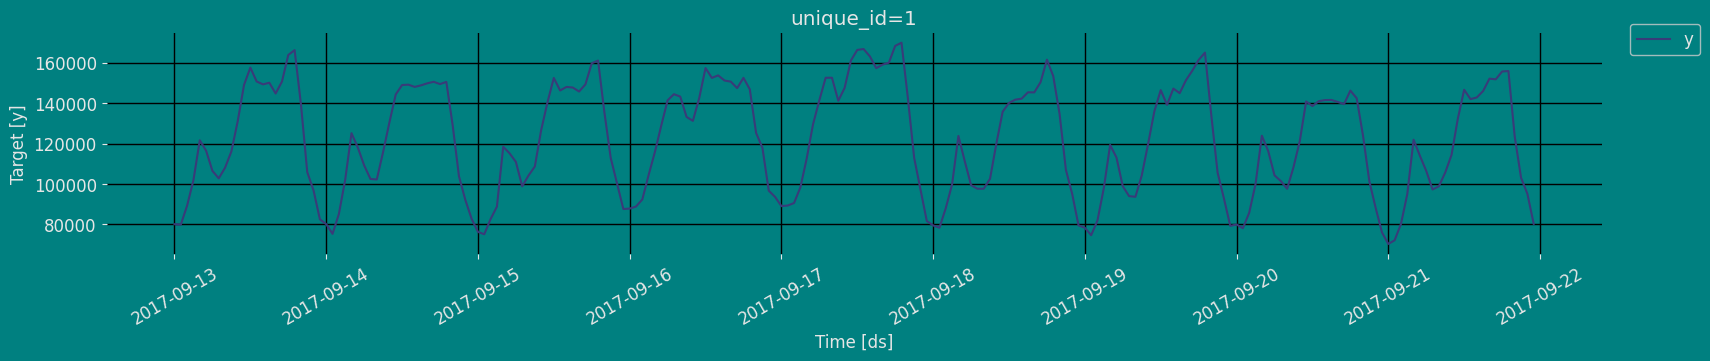

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### Autocorrelation plots

Autocorrelation (ACF) and partial autocorrelation (PACF) plots are statistical tools used to analyze time series. ACF charts show the correlation between the values of a time series and their lagged values, while PACF charts show the correlation between the values of a time series and their lagged values, after the effect of previous lagged values has been removed.

ACF and PACF charts can be used to identify the structure of a time series, which can be helpful in choosing a suitable model for the time series. For example, if the ACF chart shows a repeating peak and valley pattern, this indicates that the time series is stationary, meaning that it has the same statistical properties over time. If the PACF chart shows a pattern of rapidly decreasing spikes, this indicates that the time series is invertible, meaning it can be reversed to get a stationary time series.

The importance of the ACF and PACF charts is that they can help analysts better understand the structure of a time series. This understanding can be helpful in choosing a suitable model for the time series, which can improve the ability to predict future values of the time series.

To analyze ACF and PACF charts:

* Look for patterns in charts. Common patterns include repeating peaks and valleys, sawtooth patterns, and plateau patterns.
* Compare ACF and PACF charts. The PACF chart generally has fewer spikes than the ACF chart.
* Consider the length of the time series. ACF and PACF charts for longer time series will have more spikes.
* Use a confidence interval. The ACF and PACF plots also show confidence intervals for the autocorrelation values. If an autocorrelation value is outside the confidence interval, it is likely to be significant.

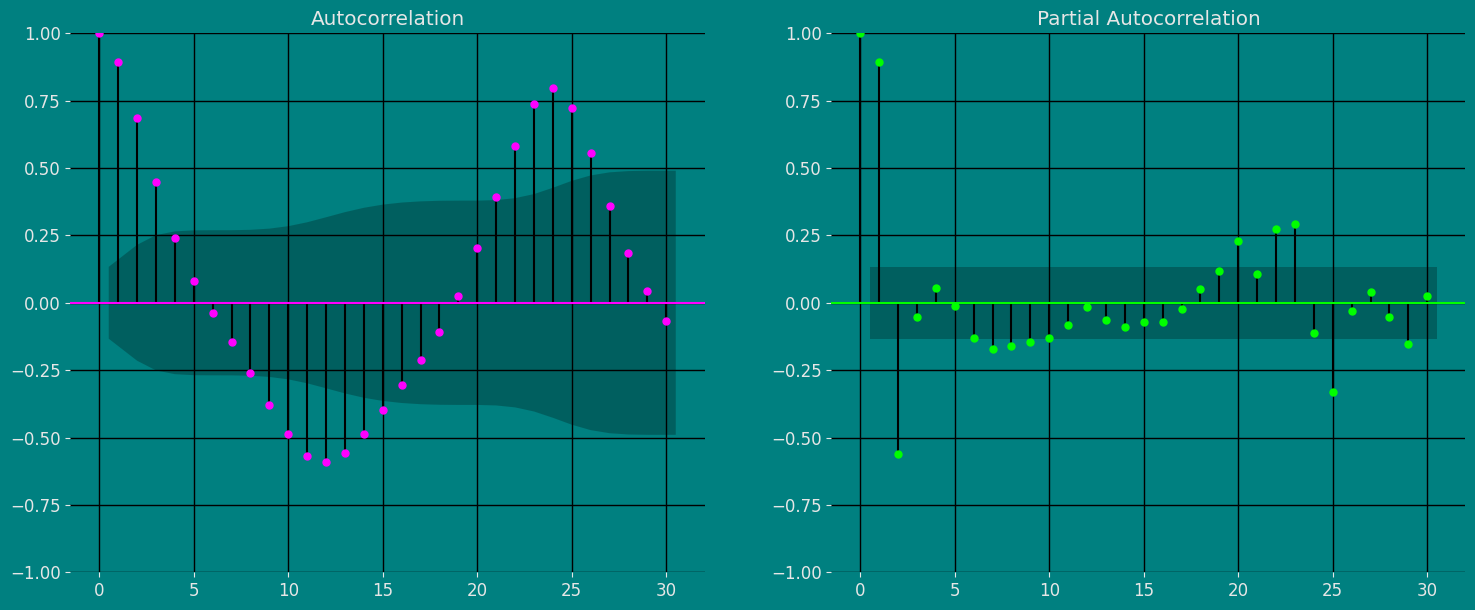

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

# Grafico
plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

### Decomposition of the time series

How to decompose a time series and why?

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

* **Level:** This is the primary value that averages over time.
* **Trend:** The trend is the value that causes increasing or decreasing patterns in a time series.
* **Seasonality:** This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
* **Residual/Noise:** These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

The combination of the components in time series can be of two types:
* Additive
* Multiplicative

### Additive time series

If the components of the time series are added to make the time series. Then the time series is called the additive time series. By visualization, we can say that the time series is additive if the increasing or decreasing pattern of the time series is similar throughout the series. The mathematical function of any additive time series can be represented by:
$$y(t) = level + Trend + seasonality + noise$$

### Multiplicative time series

If the components of the time series are multiplicative together, then the time series is called a multiplicative time series. For visualization, if the time series is having exponential growth or decline with time, then the time series can be considered as the multiplicative time series. The mathematical function of the multiplicative time series can be represented as.

$$y(t) = Level * Trend * seasonality * Noise$$

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plotSeasonalDecompose(
    x,
    model='additive',
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
    title="Seasonal Decomposition"):

    result = seasonal_decompose(
            x, model=model, filt=filt, period=period,
            two_sided=two_sided, extrapolate_trend=extrapolate_trend)
    fig = make_subplots(
            rows=4, cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"])
    for idx, col in enumerate(['observed', 'trend', 'seasonal', 'resid']):
        fig.add_trace(
            go.Scatter(x=result.observed.index, y=getattr(result, col), mode='lines'),
                row=idx+1, col=1,
            )
    return fig

In [ ]:
plotSeasonalDecompose(
    df["y"],
    model="additive",
    period=24,
    title="Seasonal Decomposition")

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets
1. Data to train our `MSTL Model`.
2. Data to test our model

For the test data we will use the last 30 Hours to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='2017-09-20 17:00:00']
test = df[df.ds>'2017-09-20 17:00:00']

In [ ]:
train.shape, test.shape

((186, 3), (30, 3))

Now let's plot the training data and the test data.

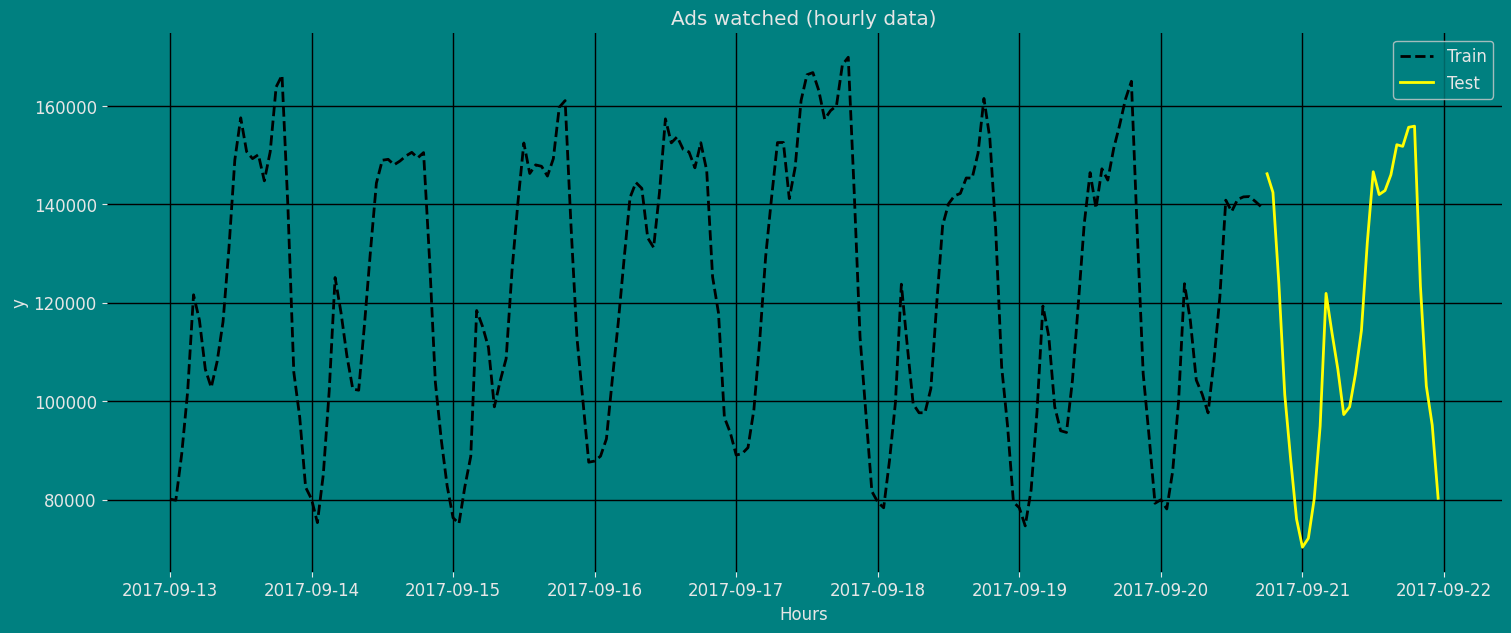

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--",linewidth=2)
sns.lineplot(test, x="ds", y="y", label="Test", linewidth=2, color="yellow")
plt.title("Ads watched (hourly data)");
plt.xlabel("Hours")
plt.show()

## Implementation of MSTL Method with StatsForecast <a class="anchor" id="implementation"></a>

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA

### Instantiating Model
Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful for `season_length`.

First, we must define the model parameters. As mentioned before, the Candy production load presents seasonalities every 24 hours (Hourly) and every 24 * 7 (Daily) hours. Therefore, we will use `[24, 24 * 7]` for season length. The trend component will be forecasted with an `AutoARIMA` model. (You can also try with: `AutoTheta`, `AutoCES`, and `AutoETS`)


In [ ]:
from statsforecast.utils import ConformalIntervals
horizon = len(test) # number of predictions

models = [MSTL(season_length=[24, 168], # seasonalities of the time series
trend_forecaster=AutoARIMA(prediction_intervals=ConformalIntervals(n_windows=3, h=horizon)))]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [pandas’ available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(models=models, freq='h')

### Fit Model

In [ ]:
sf.fit(df=train)

StatsForecast(models=[MSTL])

Let's see the results of our `MSTL Model`. We can observe it with the following instruction:

In [ ]:
result=sf.fitted_[0,0].model_
result

,data,trend,seasonal24,seasonal168,remainder
0,80115.0,126222.558267,-42511.086107,-1524.379074,-2072.093085
1,79885.0,126191.340644,-43585.928105,-1315.292640,-1405.119899
2,89325.0,126160.117727,-36756.458517,659.187427,-737.846637
...,...,...,...,...,...
183,141590.0,120314.325647,25363.015190,-2808.715638,-1278.625199
184,140610.0,120280.850692,26306.688690,-6221.712712,244.173330
185,139515.0,120247.361703,27571.777796,-5745.053631,-2559.085868


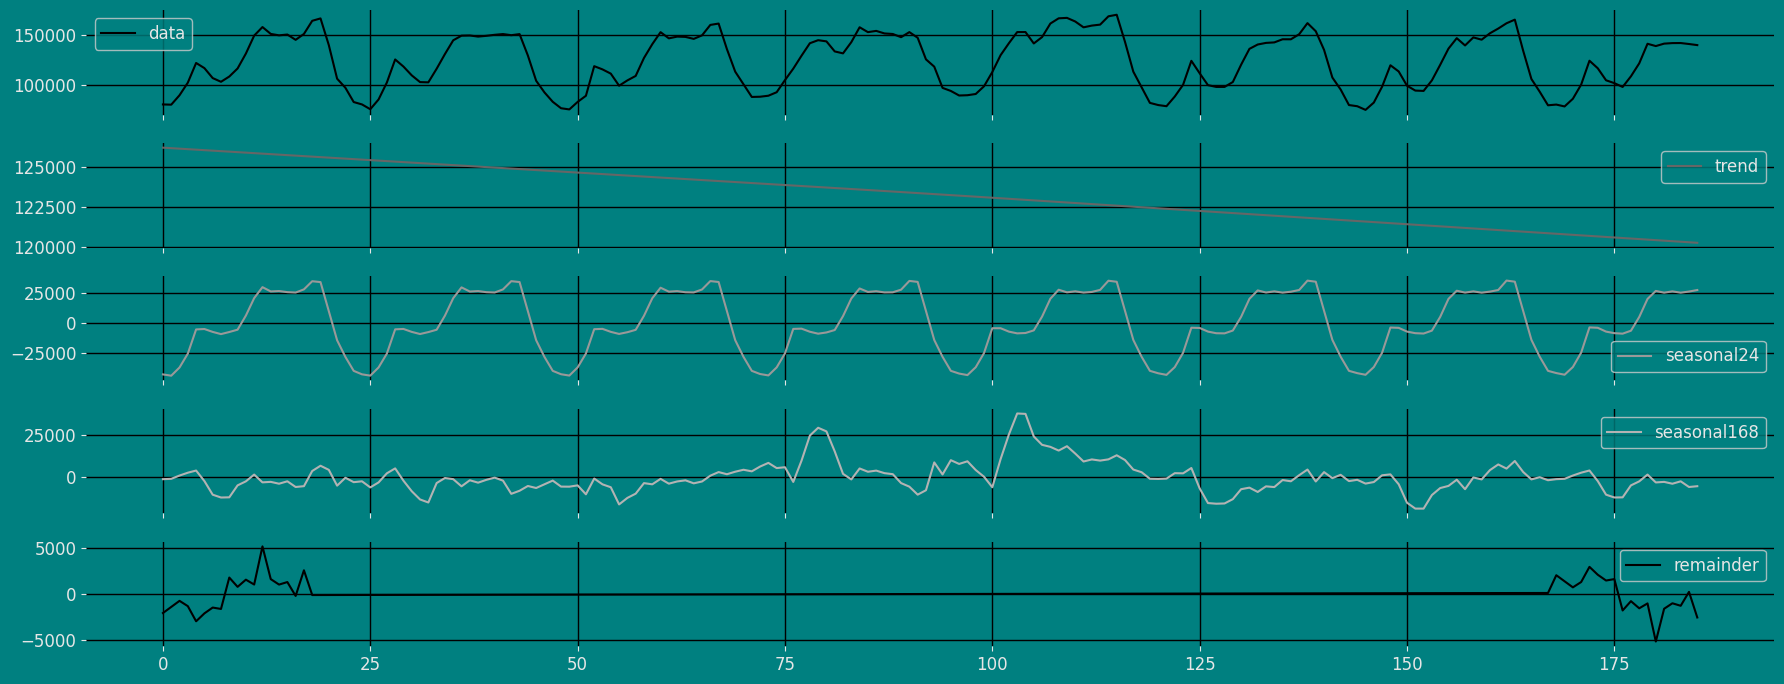

In [ ]:
sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 30 hours ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like `ARIMA` and `Theta`)

In [ ]:
Y_hat = sf.forecast(df=train, h=horizon, fitted=True)
Y_hat

,unique_id,ds,MSTL
0,1,2017-09-20 18:00:00,157848.500000
1,1,2017-09-20 19:00:00,159790.328125
2,1,2017-09-20 20:00:00,133002.281250
...,...,...,...
27,1,2017-09-21 21:00:00,98109.875000
28,1,2017-09-21 22:00:00,86342.015625
29,1,2017-09-21 23:00:00,76815.976562


In [ ]:
values=sf.forecast_fitted_values()
values.head()

,unique_id,ds,y,MSTL
0,1,2017-09-13 00:00:00,80115.0,79990.851562
1,1,2017-09-13 01:00:00,79885.0,79329.132812
2,1,2017-09-13 02:00:00,89325.0,88401.179688
3,1,2017-09-13 03:00:00,101930.0,102109.929688
4,1,2017-09-13 04:00:00,121630.0,123543.671875


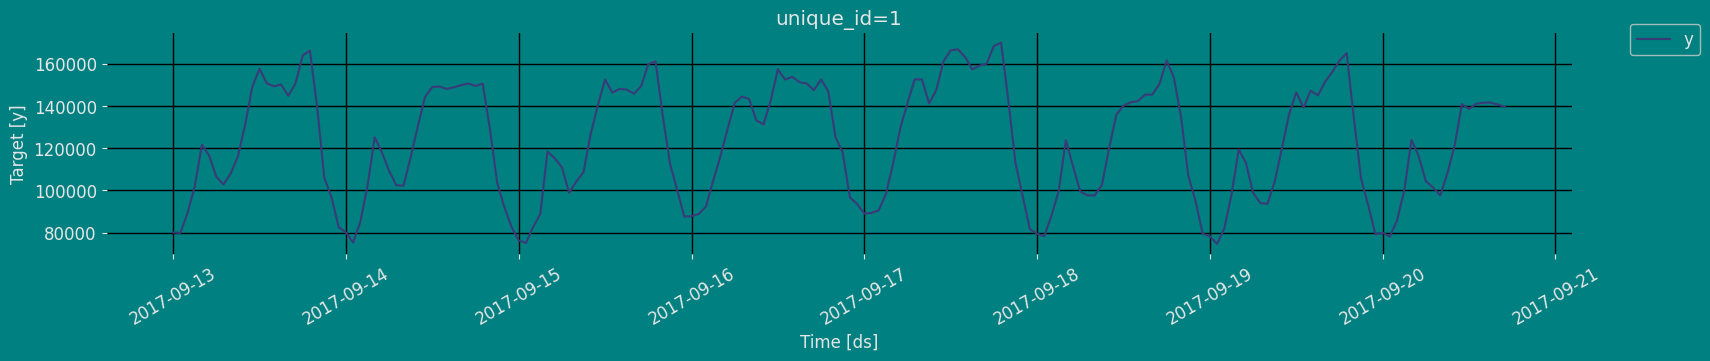

In [ ]:
StatsForecast.plot(values)

Adding 95% confidence interval with the forecast method

In [ ]:
sf.forecast(df=train, h=horizon, level=[95])

,unique_id,ds,MSTL,MSTL-lo-95,MSTL-hi-95
0,1,2017-09-20 18:00:00,157848.500000,157796.406250,157900.593750
1,1,2017-09-20 19:00:00,159790.328125,159714.218750,159866.437500
2,1,2017-09-20 20:00:00,133002.281250,132893.937500,133110.609375
...,...,...,...,...,...
27,1,2017-09-21 21:00:00,98109.875000,95957.031250,100262.726562
28,1,2017-09-21 22:00:00,86342.015625,85410.578125,87273.460938
29,1,2017-09-21 23:00:00,76815.976562,73476.195312,80155.757812


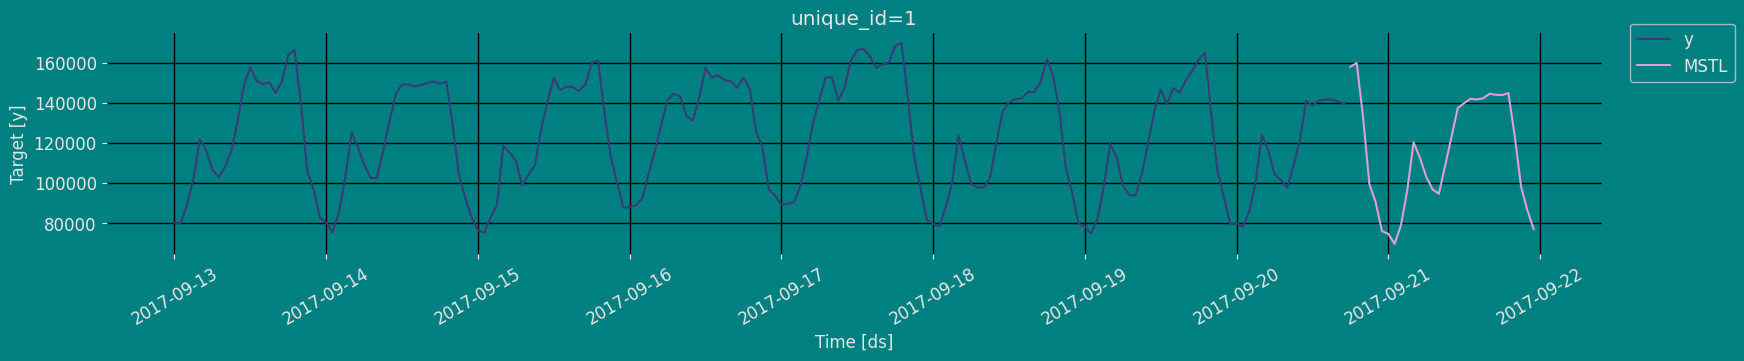

In [ ]:
sf.plot(train, Y_hat)

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 30 hours ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[95]` means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
sf.predict(h=horizon)

,unique_id,ds,MSTL
0,1,2017-09-20 18:00:00,157848.500000
1,1,2017-09-20 19:00:00,159790.328125
2,1,2017-09-20 20:00:00,133002.281250
...,...,...,...
27,1,2017-09-21 21:00:00,98109.875000
28,1,2017-09-21 22:00:00,86342.015625
29,1,2017-09-21 23:00:00,76815.976562


In [ ]:
forecast_df = sf.predict(h=horizon, level=[80,95])
forecast_df

,unique_id,ds,MSTL,MSTL-lo-95,MSTL-lo-80,MSTL-hi-80,MSTL-hi-95
0,1,2017-09-20 18:00:00,157848.500000,157796.406250,157798.484375,157898.531250,157900.593750
1,1,2017-09-20 19:00:00,159790.328125,159714.218750,159716.187500,159864.468750,159866.437500
2,1,2017-09-20 20:00:00,133002.281250,132893.937500,132894.515625,133110.031250,133110.609375
...,...,...,...,...,...,...,...
27,1,2017-09-21 21:00:00,98109.875000,95957.031250,96493.921875,99725.828125,100262.726562
28,1,2017-09-21 22:00:00,86342.015625,85410.578125,85411.835938,87272.195312,87273.460938
29,1,2017-09-21 23:00:00,76815.976562,73476.195312,74494.546875,79137.406250,80155.757812


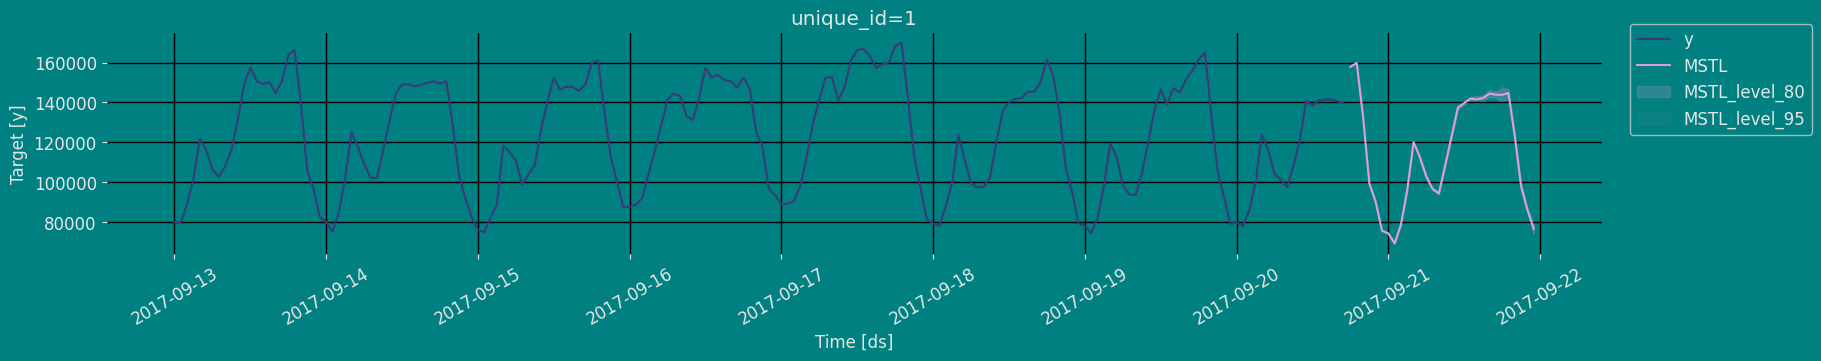

In [ ]:
sf.plot(train, forecast_df, level=[80, 95])

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=)`, forecasting every second months `(step_size=50)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 500 hours ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=df,
                                         h=horizon,
                                         step_size=30,
                                         n_windows=5)

The crossvaldation_df object is a new data frame that includes the following columns:

* `unique_id:` series identifier
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the `n_windows`.
* `y:` true value
* `model:` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,unique_id,ds,cutoff,y,MSTL
0,1,2017-09-15 18:00:00,2017-09-15 17:00:00,159725.0,158384.250000
1,1,2017-09-15 19:00:00,2017-09-15 17:00:00,161085.0,162015.171875
2,1,2017-09-15 20:00:00,2017-09-15 17:00:00,135520.0,138495.093750
...,...,...,...,...,...
147,1,2017-09-21 21:00:00,2017-09-20 17:00:00,103080.0,98109.875000
148,1,2017-09-21 22:00:00,2017-09-20 17:00:00,95155.0,86342.015625
149,1,2017-09-21 23:00:00,2017-09-20 17:00:00,80285.0,76815.976562


We’ll now plot the forecast for each cutoff period. To make the plots clearer, we’ll rename the actual values in each period.

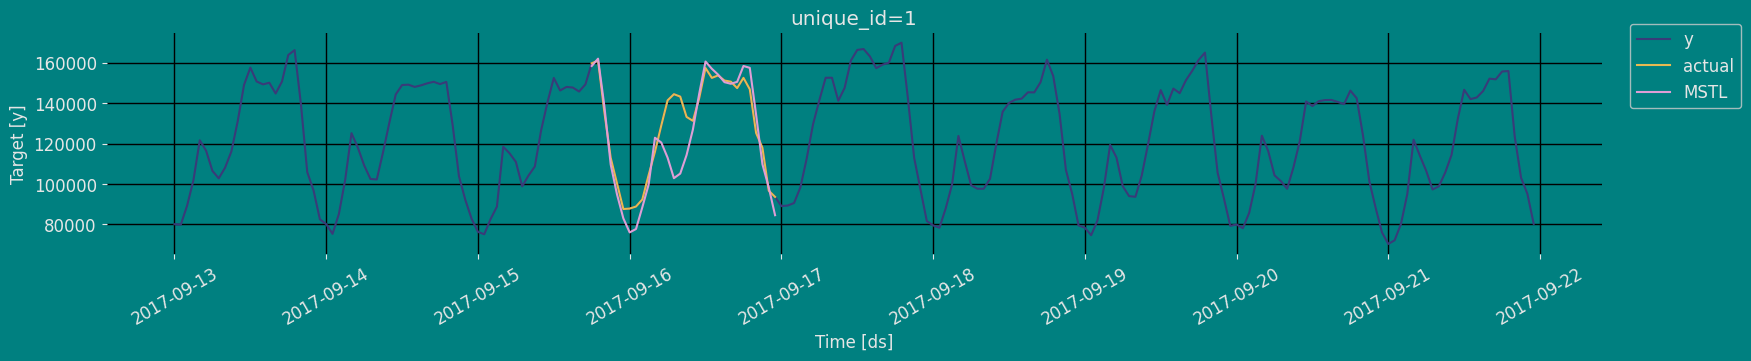

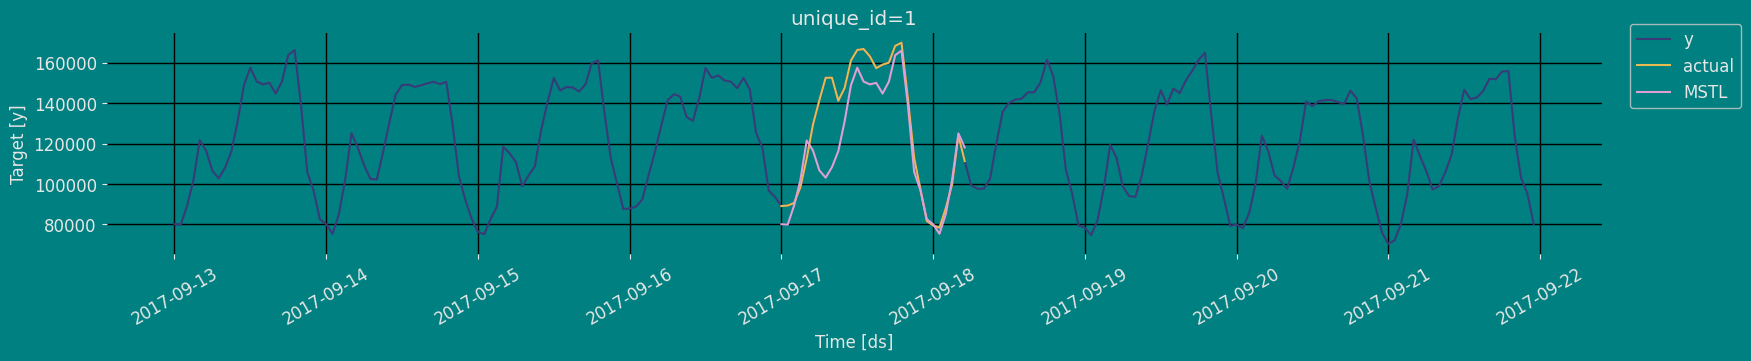

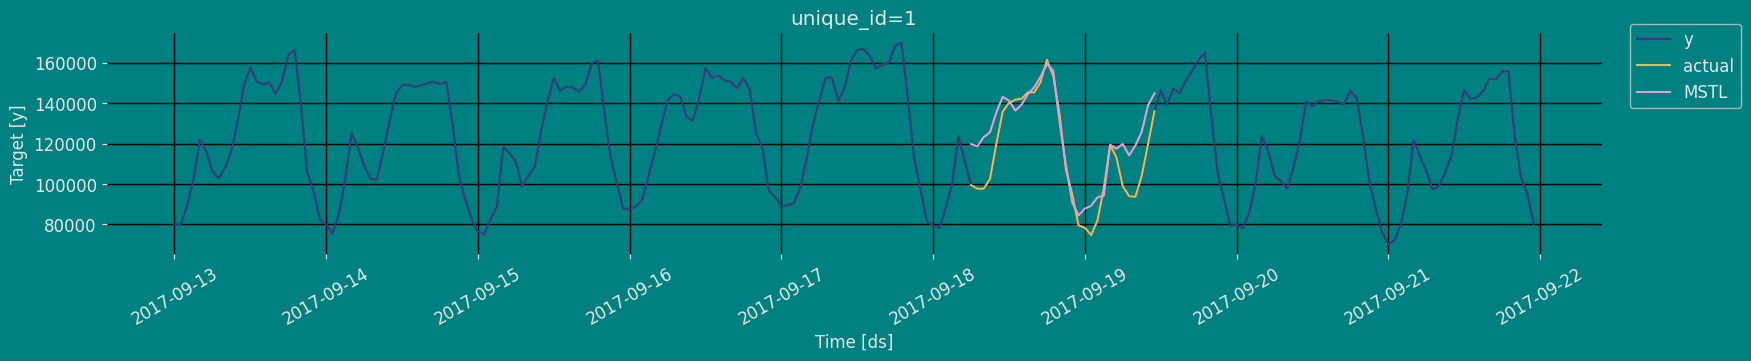

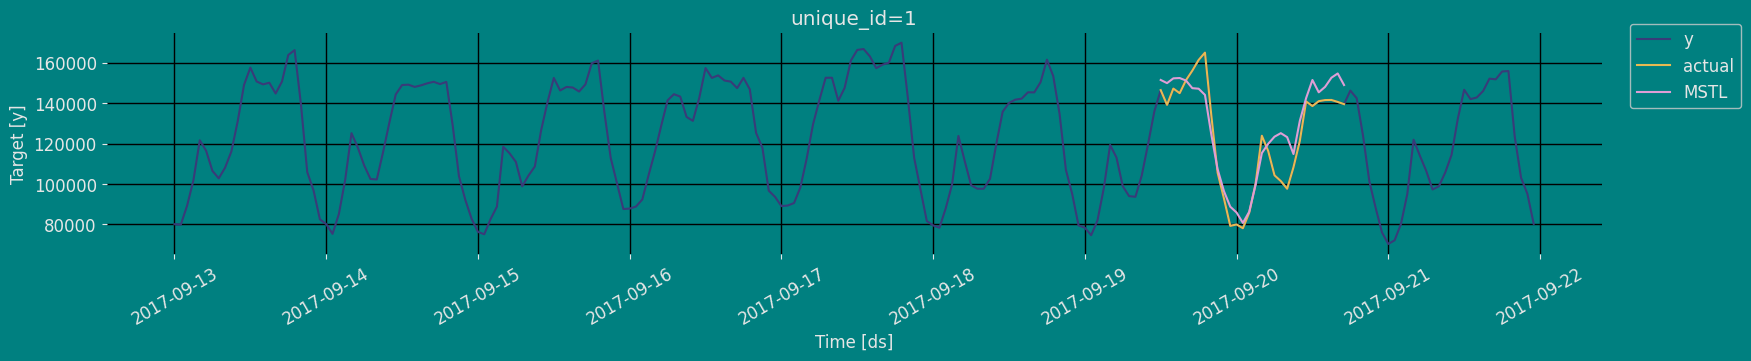

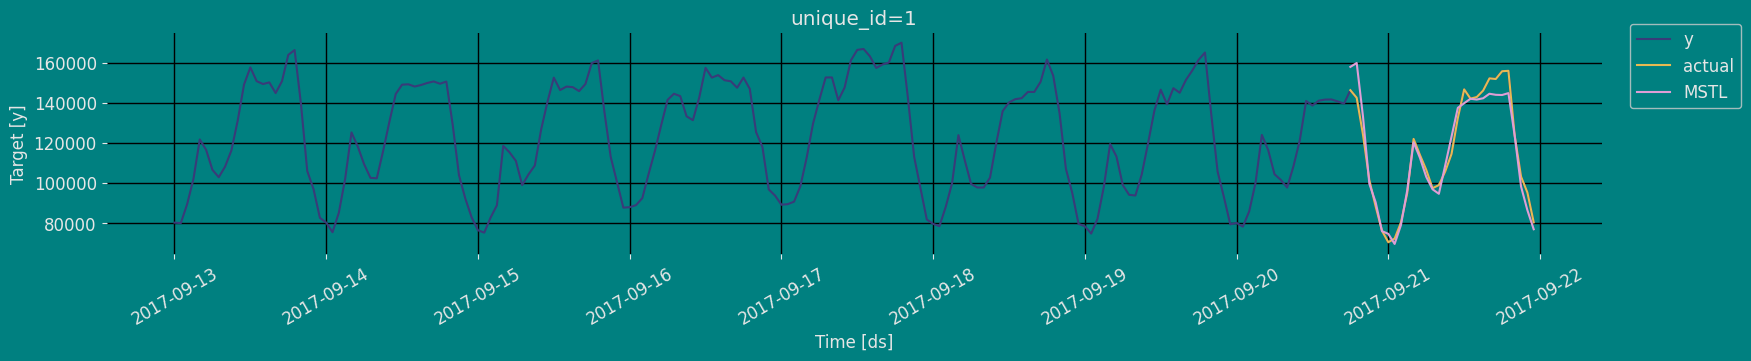

In [ ]:
from IPython.display import display

cross_validation=crossvalidation_df.copy()
cross_validation.rename(columns = {'y' : 'actual'}, inplace = True) # rename actual values

cutoff = cross_validation['cutoff'].unique()

for k in range(len(cutoff)):
    cv = cross_validation[cross_validation['cutoff'] == cutoff[k]]
    display(StatsForecast.plot(df, cv.loc[:, cv.columns != 'cutoff']))

## Model Evaluation <a class="anchor" id="evaluate"></a>

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics MAE, MAPE, MASE, RMSE, SMAPE to evaluate the accuracy.

In [ ]:
from functools import partial

import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

In [ ]:
evaluate(
    test.merge(Y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=train,
)

,unique_id,metric,MSTL
0,1,mae,4932.395052
1,1,mape,0.040514
2,1,mase,0.609407
3,1,rmse,6495.207028
4,1,smape,0.020267


## References <a class="anchor" id="references"></a>

1. [Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python.](https://link.springer.com/book/10.1007/978-3-031-13584-2) 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla MultipleSeasonalTrend API](../../models#class-mstl)
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).